In [20]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


AttributeError: module 'matplotlib' has no attribute 'artist'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h',name=""):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.savefig(f'{name}_cumulative_return.png')
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.savefig(f'{name}_signal_weight.png')
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [ ]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")
df = pd.read_parquet("../data/full_dataset_feature_engineering_v1.parquet")

In [ ]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")
reddit_results.rename(columns={"date": "date_hour"}, inplace=True)
reddit_results.set_index("date_hour", inplace=True)

reddit_results

,total_sentiment,average_sentiment
date_hour,,
2021-01-01 00:00:00,0.2966,0.015611
2021-01-01 01:00:00,1.6673,0.049038
2021-01-01 02:00:00,0.4588,0.021848
2021-01-01 03:00:00,-0.4329,-0.020614
2021-01-01 04:00:00,0.0000,0.000000
...,...,...
2024-12-31 19:00:00,0.0000,0.000000
2024-12-31 20:00:00,0.0000,0.000000
2024-12-31 21:00:00,0.0000,0.000000


In [ ]:
btc_ner = pd.read_parquet("/workspaces/fyp/crypto_news/data/7a.News_by_hour_filled_return_ner.parquet")
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_col = "target"

start_date = pd.to_datetime("2021-01-01 10:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,56.533261,317.624467,353.808641,367.447718,29496.559713,29199.137,28901.714287,29578.630359,28970.1450,28361.659641
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,56.598884,295.260971,340.042309,357.620684,29502.574589,29203.857,28905.139411,29589.347989,28974.4195,28359.491011
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,54.726979,304.073690,341.250001,357.588747,29487.240223,29221.956,28956.671777,29606.981982,28986.3910,28365.800018
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,52.258691,303.448877,338.282144,354.832140,29491.227042,29215.220,28939.212958,29610.913197,29006.8125,28402.711803
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,56.754682,310.279037,339.209134,354.662038,29478.397134,29244.203,29010.008866,29621.265856,29043.1435,28465.021144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.700,93232.332124,95433.425204,94002.9000,92572.374796
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.600,93046.804693,95435.711991,93998.4000,92561.088009
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.000,92943.728190,95434.444994,94007.2500,92580.055006


In [ ]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
price_indicator_2024.index = pd.to_datetime(price_indicator_2024.index)
btc_ner.index = pd.to_datetime(btc_ner.index)
reddit_results.index = pd.to_datetime(reddit_results.index)

# Merge the DataFrames on the index (date_hour)
merged_df = pd.concat([price_indicator_2024, reddit_results], axis=1)

# Drop any rows with missing values (optional, if needed)
merged_df.dropna(inplace=True)

# Verify the merged DataFrame
# merged_df.drop("target",axis=1)
merged_df

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,353.808641,367.447718,29496.559713,29199.137,28901.714287,29578.630359,28970.1450,28361.659641,0.0000,0.000000
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,340.042309,357.620684,29502.574589,29203.857,28905.139411,29589.347989,28974.4195,28359.491011,0.0000,0.000000
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,341.250001,357.588747,29487.240223,29221.956,28956.671777,29606.981982,28986.3910,28365.800018,0.0000,0.000000
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,338.282144,354.832140,29491.227042,29215.220,28939.212958,29610.913197,29006.8125,28402.711803,0.8402,0.056013
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,339.209134,354.662038,29478.397134,29244.203,29010.008866,29621.265856,29043.1435,28465.021144,0.4404,0.017616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,594.021005,490.327871,95801.067876,94516.700,93232.332124,95433.425204,94002.9000,92572.374796,0.0000,0.000000
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,605.805219,503.121782,95876.395307,94461.600,93046.804693,95435.711991,93998.4000,92561.088009,0.0000,0.000000
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,594.033418,500.163602,95898.271810,94421.000,92943.728190,95434.444994,94007.2500,92580.055006,0.0000,0.000000


In [ ]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
1970-01-01 00:00:00.000000000,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000001,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000002,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000003,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000004,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000032087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
btc_ner.set_index("date_hour", inplace=True)
merged_df = pd.merge(merged_df, btc_ner, on='date_hour', how='inner')
merged_df


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.drop(columns=['target'], inplace=True)

# Statistical Feature Selection

In [ ]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,-0.001385,143.55,210.51,-647.125,123.182375,73.241757,-290.164294,-3.40,-0.023137,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.000729,151.35,210.81,-631.665,101.159360,74.849008,-282.793610,7.80,0.054336,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.005929,120.60,219.66,-617.505,77.283277,74.229918,-276.579317,-30.75,-0.203171,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.000095,43.45,223.39,-605.320,0.428392,59.296872,-277.935098,-77.15,-0.639718,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.005017,-37.10,221.12,-591.100,-44.989742,46.318484,-278.999237,-80.55,-1.853855,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,-0.006308,339.30,312.86,-1716.765,92.250077,114.783572,-1486.632740,-329.95,-0.493015,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.002858,-30.20,309.90,-1704.440,-105.563575,70.973167,-1489.015782,-369.50,-1.089007,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,-0.004142,-238.45,313.73,-1694.035,-157.957093,47.582523,-1482.887694,-208.25,6.895695,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.000933,-365.30,310.76,-1696.715,-276.925974,5.335072,-1487.834867,-126.85,0.531977,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


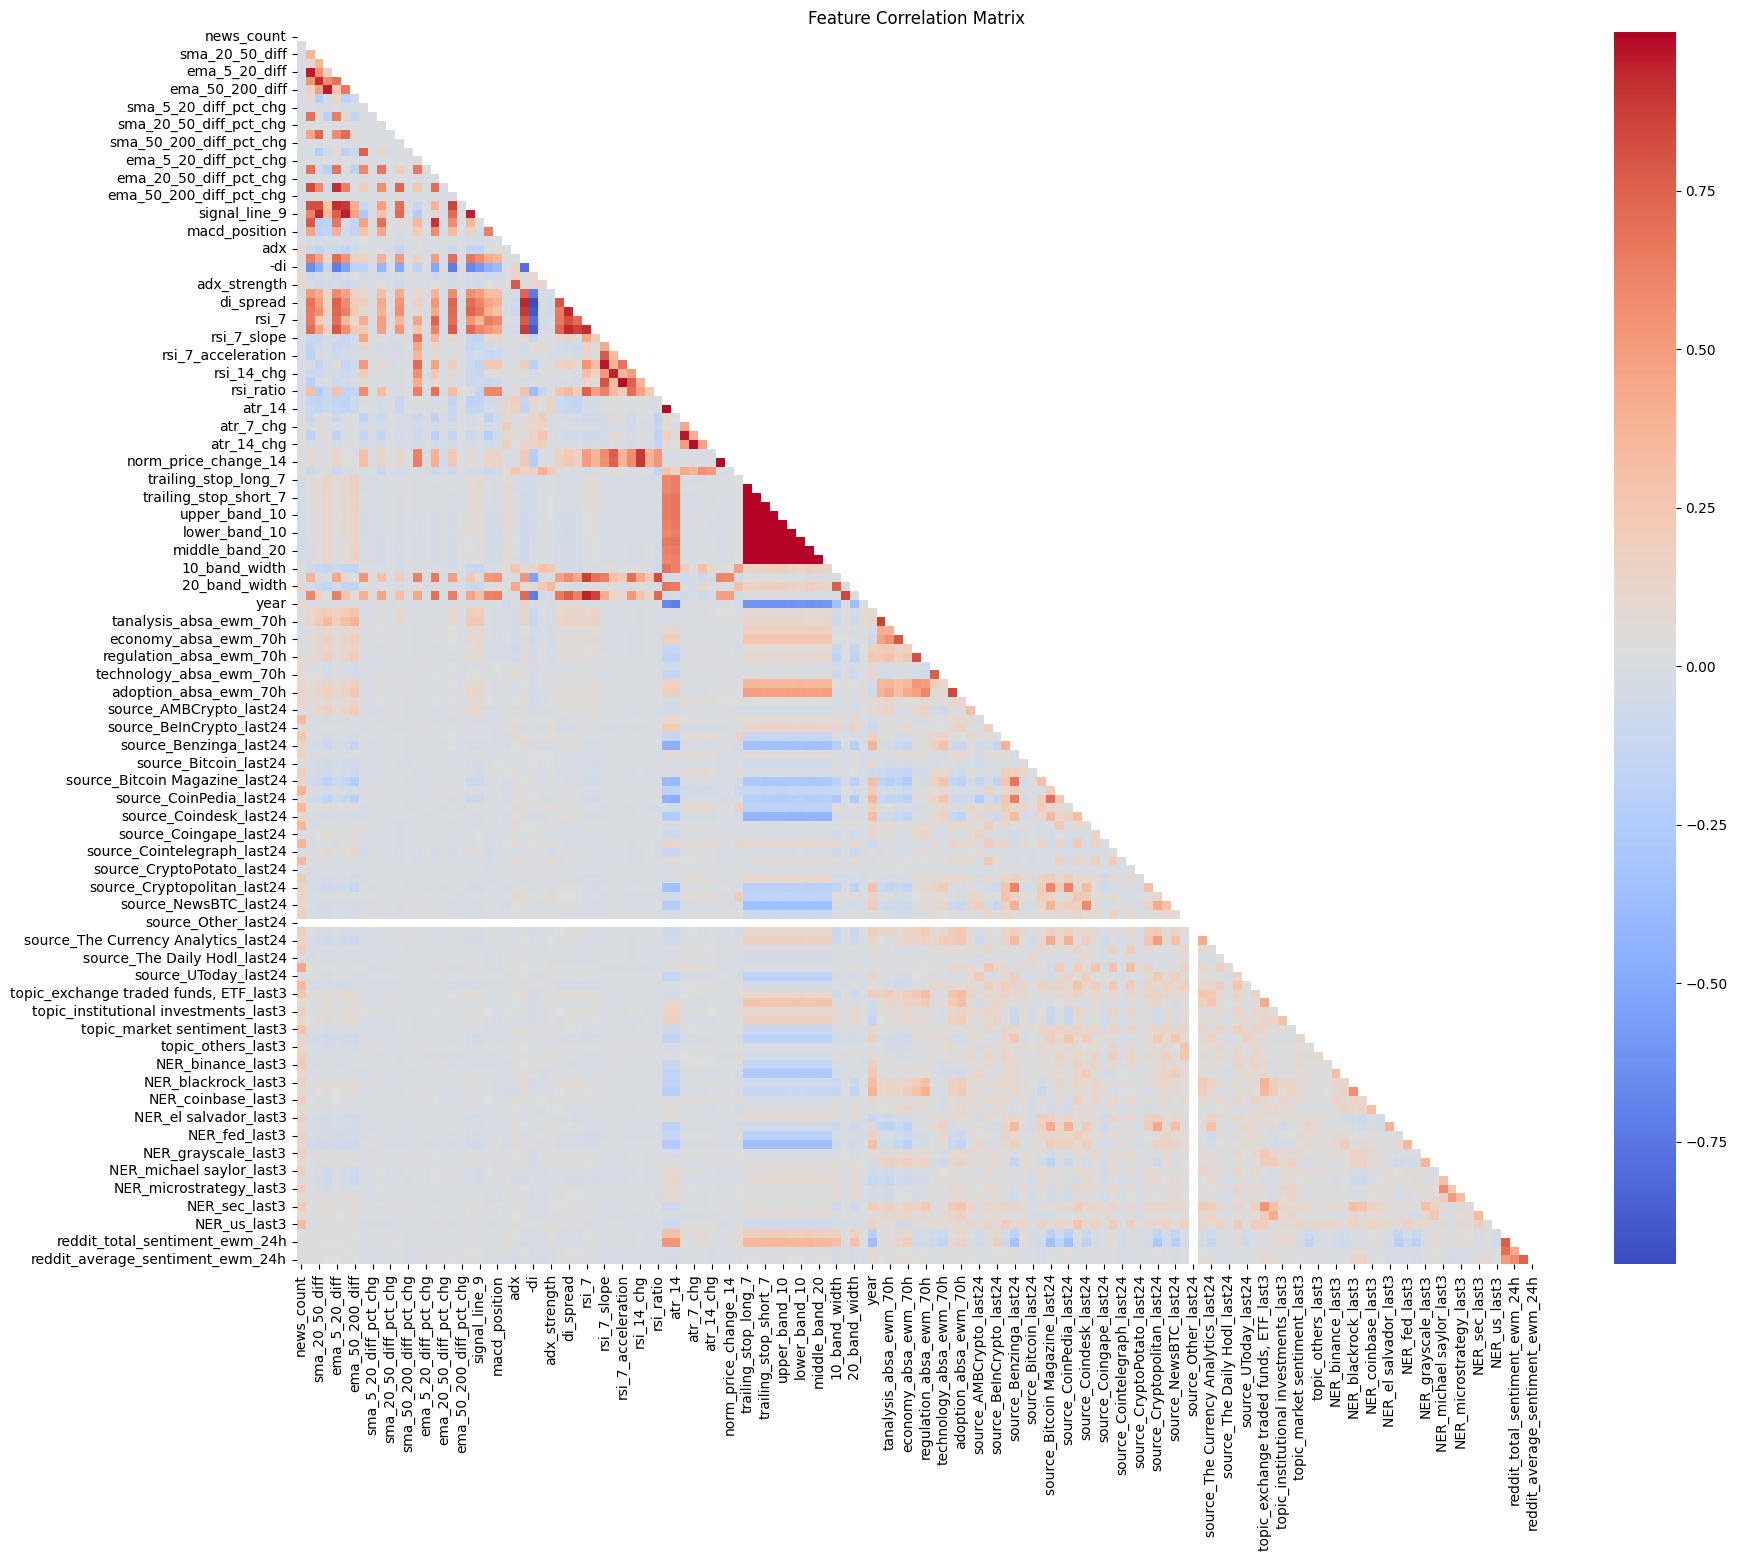

In [ ]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 139 to 106
Top features selected: ['sma_5_20_diff_abs_chg', 'ema_5_20_diff_abs_chg', 'ema_50_200_diff_abs_chg', 'atr_7_slope', 'atr_14_slope', '10_band_width', 'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h', 'economy_absa_ewm_70h', 'adoption_absa_ewm_12h', 'adoption_absa_ewm_70h', 'source_AMBCrypto_last3', 'source_Bitcoin Magazine_last24', 'source_CoinPedia_last24', 'reddit_total_sentiment_ewm_5h']


Index(['sma_5_20_diff_abs_chg', 'ema_5_20_diff_abs_chg',
       'ema_50_200_diff_abs_chg', 'atr_7_slope', 'atr_14_slope',
       '10_band_width', 'tanalysis_absa_ewm_12h', 'tanalysis_absa_ewm_70h',
       'economy_absa_ewm_70h', 'adoption_absa_ewm_12h',
       'adoption_absa_ewm_70h', 'source_AMBCrypto_last3',
       'source_Bitcoin Magazine_last24', 'source_CoinPedia_last24',
       'reddit_total_sentiment_ewm_5h'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26284
Testing sequences: 8762


In [ ]:
# In the cell corresponding to id '90ec3b2b' (or similar model definition cell)

# ... existing imports ...
from tensorflow.keras.models import Sequential
# Add CNN layers to imports
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
import tensorflow as tf # Ensure tensorflow is imported
from tensorflow.keras.callbacks import LearningRateScheduler
# ... (Keep the sharpe_loss function definition if needed, or remove if using MSE) ...
# Assuming you want to keep the MSE loss as per the original cell:
# Remove or comment out the sharpe_loss definition and registration if not used.
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# --- Define CNN-LSTM Model Architecture ---
# Assuming X_train has shape (samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2]) 

model = Sequential() # Rename cnn_lstm_model to model to match existing code flow

# CNN Part
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same')) # Added padding
model.add(MaxPooling1D(pool_size=2))
# No Flatten needed if LSTM follows directly

# LSTM Part
model.add(LSTM(50, activation='relu', return_sequences=False)) # Changed units to 50, kept relu, return_sequences=False
model.add(Dropout(0.2)) # Kept dropout

# Dense Part (Simplified to match original LSTM output structure)
# model.add(Dense(25, activation='relu')) # Optional intermediate dense layer
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model (Matches the original cell's compilation)
model.compile(optimizer='adam', loss="mean_squared_error")

# Print model summary
model.summary()

# Add early stopping (Matches the original cell)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model (Matches the original cell)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model (Matches the original cell)
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions (Matches the original cell)
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (Matches the original cell)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
# The 'predictions' variable now holds the output, consistent with the rest of the notebook
# print(predictions) # Optional: print predictions if needed here

2025-04-16 13:50:21.157008: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,995 (101.54 KB)

 Trainable params: 25,995 (101.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0145 - val_loss: 2.9535e-04 - learning_rate: 0.0010
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0028 - val_loss: 3.1868e-04 - learning_rate: 0.0010
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - val_loss: 3.0212e-04 - learning_rate: 0.0010
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016 - val_loss: 2.5721e-04 - learning_rate: 0.0010
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 2.6716e-04 - learning_rate: 0.0010
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 2.5716e-04 - learning_rate: 0.0010
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 2.5761e-04 - learning_rate: 0.0010
Epoch 8/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 2.5646e-04 - learning_rate: 0.0010
Epoch 9/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7026e-04 - val_lo

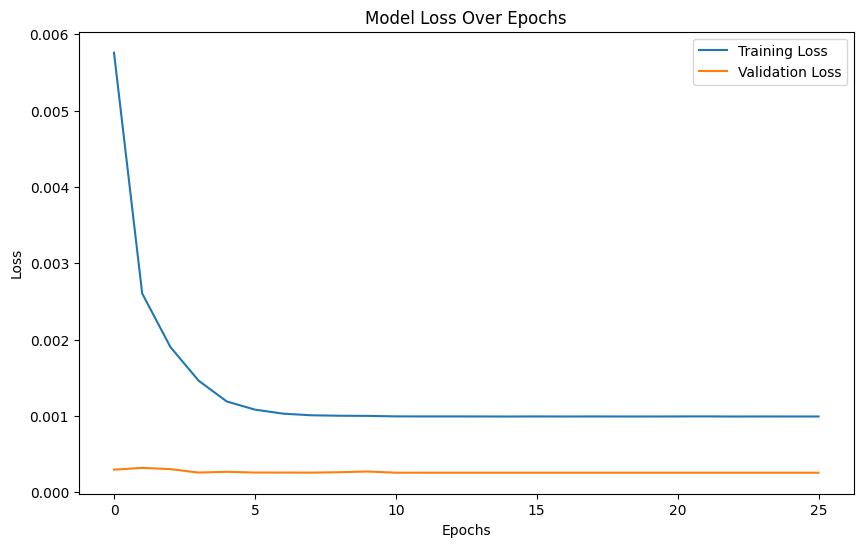

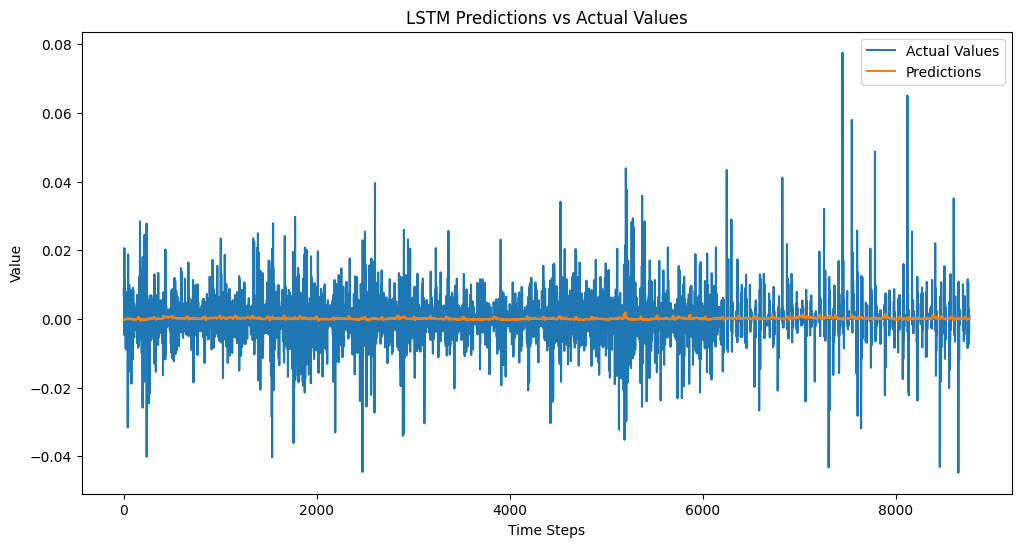

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
model.save('stat_selection_lstm_cnn.keras')  # HDF5 format


In [ ]:
y_test

array([[0.53007255],
       [0.53878388],
       [0.5181776 ],
       ...,
       [0.48469075],
       [0.50521762],
       [0.502052  ]])

In [24]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

model = load_model('stat_selection_lstm_cnn.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


AttributeError: module 'matplotlib' has no attribute 'artist'

In [ ]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.00001 else (-1 if x < -0.00001 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0.00001 else (-1 if x < -0.00001 else 0))

stat_signal_result_df

,Predicted,signal,target
2024-01-01 22:00:00,-0.000211,-1,1
2024-01-01 23:00:00,-0.000267,-1,1
2024-01-02 00:00:00,-0.000278,-1,1
2024-01-02 01:00:00,-0.000294,-1,-1
2024-01-02 02:00:00,-0.000241,-1,-1
...,...,...,...
2024-12-31 19:00:00,0.000163,1,-1
2024-12-31 20:00:00,0.000206,1,1
2024-12-31 21:00:00,0.000177,1,-1
2024-12-31 22:00:00,0.000184,1,1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.4076
Precision (Weighted): 0.3809
Recall (Weighted): 0.4076
F1 Score (Weighted): 0.3601
\nMetrics per class:
  Class -1:
    Precision: 0.4467
    Recall:    0.2710
    F1 Score:  0.3373
  Class 0:
    Precision: 0.1827
    Recall:    0.0354
    F1 Score:  0.0593
  Class 1:
    Precision: 0.4056
    Recall:    0.7001
    F1 Score:  0.5136


Overall Annual Return: 40.02%
Overall Annual Sharpe Ratio: 0.9054
Maximum Drawdown: -47.42 %
Alpha: -0.0367
Beta: 0.5504

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.400175    0.522829     0.550432     -0.037428       0.905368


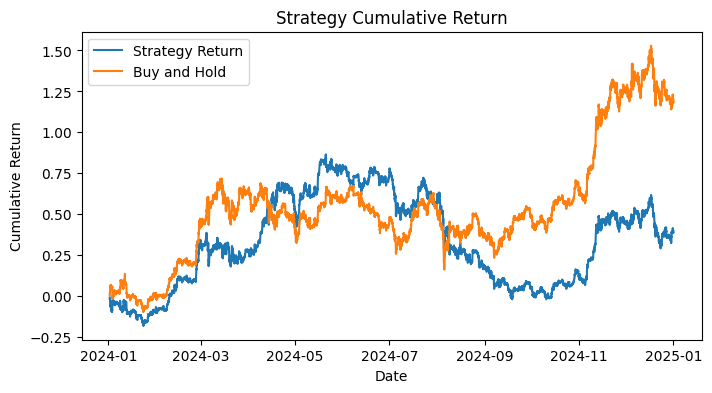

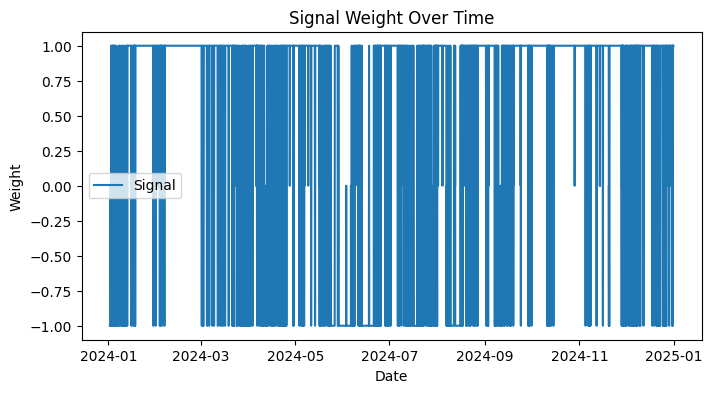

In [ ]:
run_backtest(stat_signal_result_df,name= "LSTM_CNN_Stat")

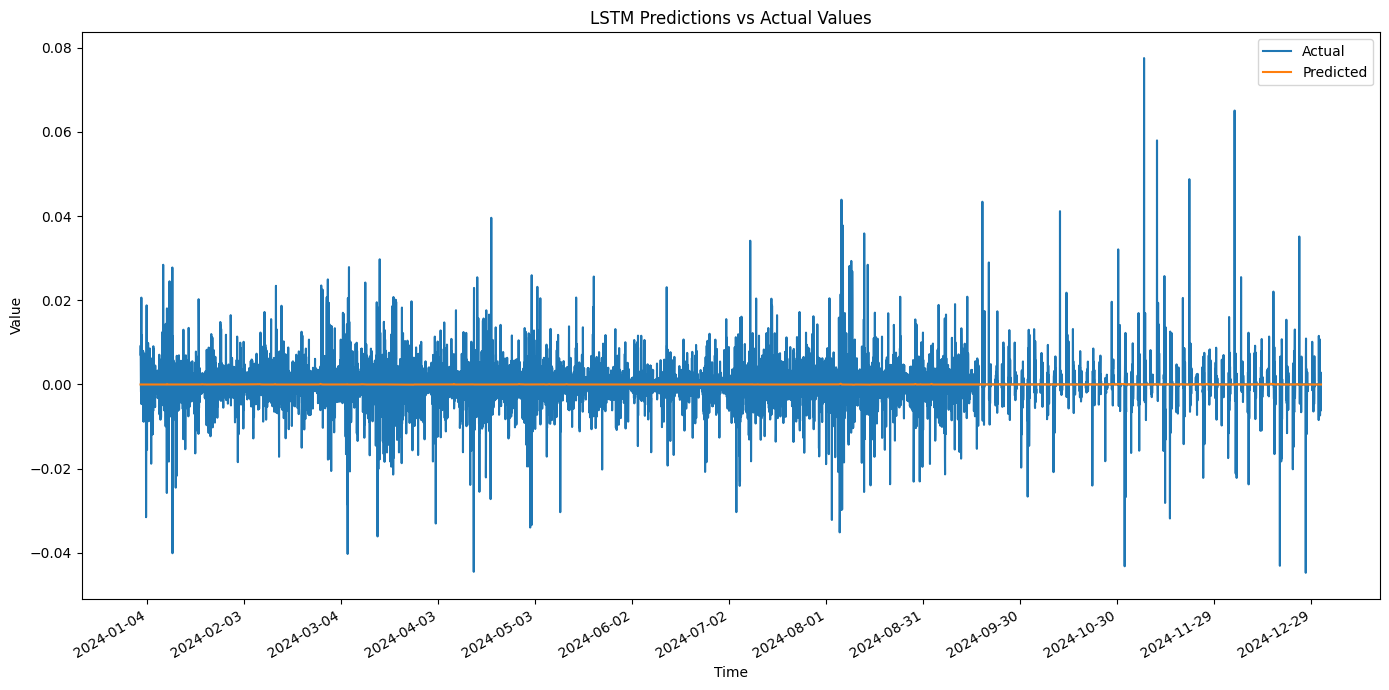

In [ ]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[lstm_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26284
Testing sequences: 8762


In [ ]:
# In the cell corresponding to id '90ec3b2b' (or similar model definition cell)

# ... existing imports ...
from tensorflow.keras.models import Sequential
# Add CNN layers to imports
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
import tensorflow as tf # Ensure tensorflow is imported
from tensorflow.keras.callbacks import LearningRateScheduler
# ... (Keep the sharpe_loss function definition if needed, or remove if using MSE) ...
# Assuming you want to keep the MSE loss as per the original cell:
# Remove or comment out the sharpe_loss definition and registration if not used.
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# --- Define CNN-LSTM Model Architecture ---
# Assuming X_train has shape (samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2]) 

model = Sequential() # Rename cnn_lstm_model to model to match existing code flow

# CNN Part
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same')) # Added padding
model.add(MaxPooling1D(pool_size=2))
# No Flatten needed if LSTM follows directly

# LSTM Part
model.add(LSTM(50, activation='relu', return_sequences=False)) # Changed units to 50, kept relu, return_sequences=False
model.add(Dropout(0.2)) # Kept dropout

# Dense Part (Simplified to match original LSTM output structure)
# model.add(Dense(25, activation='relu')) # Optional intermediate dense layer
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model (Matches the original cell's compilation)
model.compile(optimizer='adam', loss="mean_squared_error")

# Print model summary
model.summary()

# Add early stopping (Matches the original cell)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model (Matches the original cell)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model (Matches the original cell)
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions (Matches the original cell)
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (Matches the original cell)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
# The 'predictions' variable now holds the output, consistent with the rest of the notebook
# print(predictions) # Optional: print predictions if needed here

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,995 (101.54 KB)

 Trainable params: 25,995 (101.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0116 - val_loss: 2.9172e-04 - learning_rate: 0.0010
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0027 - val_loss: 2.7649e-04 - learning_rate: 0.0010
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0019 - val_loss: 2.6656e-04 - learning_rate: 0.0010
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 2.5770e-04 - learning_rate: 0.0010
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 2.5603e-04 - learning_rate: 0.0010
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 2.8419e-04 - learning_rate: 0.0010
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 2.5752e-04 - learning_rate: 0.0010
Epoch 8/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 2.5522e-04 - learning_rate: 0.0010
Epoch 9/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9867e-04 - val_lo

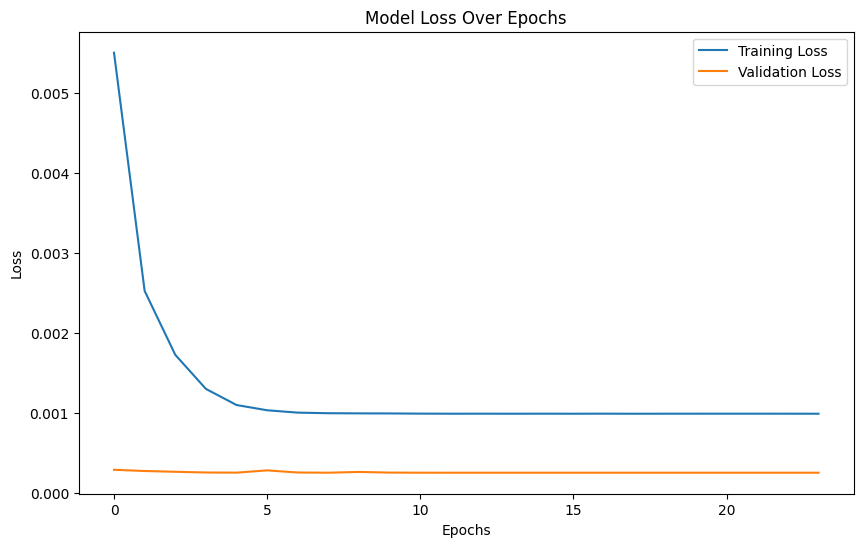

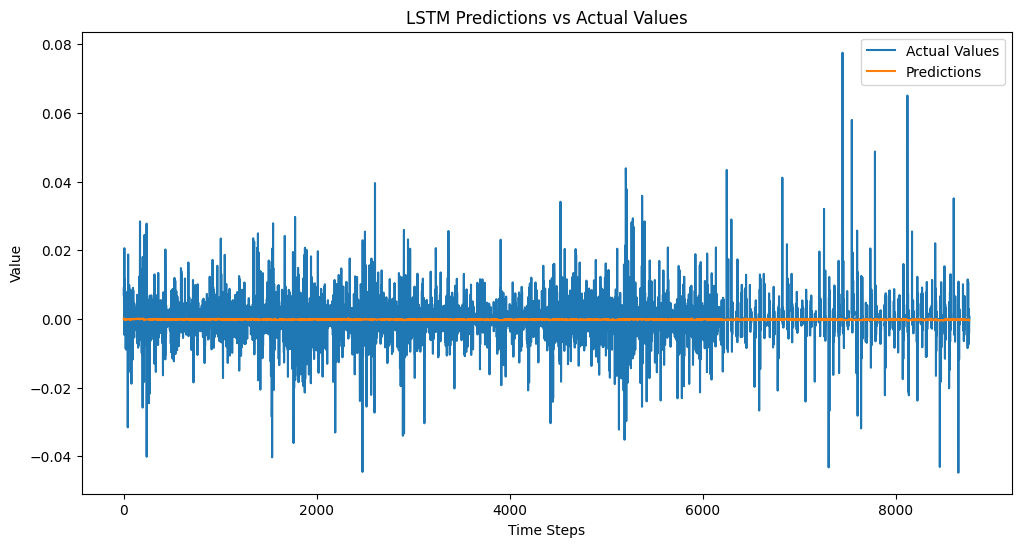

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pickle

# # Save feature scaler
# with open('feature_scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# # Save target scaler (if used)
# with open('target_scaler.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)
    
# # Save feature list
# with open('selected_features.pkl', 'wb') as file:
#     pickle.dump(selected_features, file)

model.save('seq_selection_lstm_cnn.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('seq_selection_lstm_cnn.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < 0.0001 else 0))

stat_signal_result_df

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Predicted,signal,target
2024-01-01 22:00:00,-0.000007,-1,1
2024-01-01 23:00:00,-0.000062,-1,1
2024-01-02 00:00:00,0.000119,1,1
2024-01-02 01:00:00,-0.000067,-1,-1
2024-01-02 02:00:00,-0.000097,-1,-1
...,...,...,...
2024-12-31 19:00:00,-0.000284,-1,-1
2024-12-31 20:00:00,-0.000270,-1,1
2024-12-31 21:00:00,-0.000257,-1,-1
2024-12-31 22:00:00,-0.000277,-1,1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.5902
Precision (Weighted): 0.5582
Recall (Weighted): 0.5902
F1 Score (Weighted): 0.4590
\nMetrics per class:
  Class -1:
    Precision: 0.5922
    Recall:    0.9795
    F1 Score:  0.7381
  Class 1:
    Precision: 0.5093
    Recall:    0.0306
    F1 Score:  0.0577


Overall Annual Return: -60.83%
Overall Annual Sharpe Ratio: -1.5109
Maximum Drawdown: -67.95 %
Alpha: 0.0897
Beta: -0.9525

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.608346    0.528118    -0.952503       0.08594      -1.510926


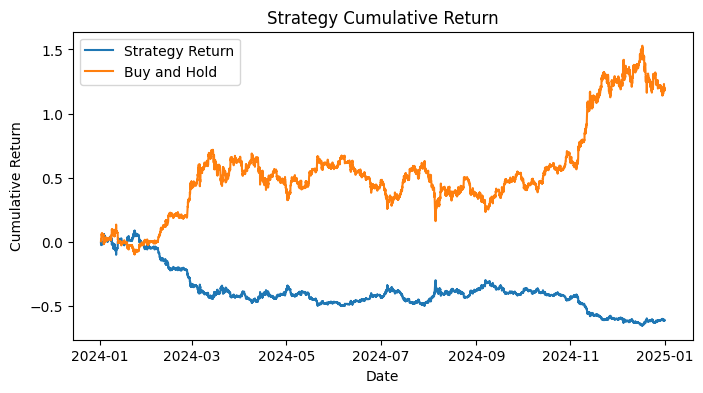

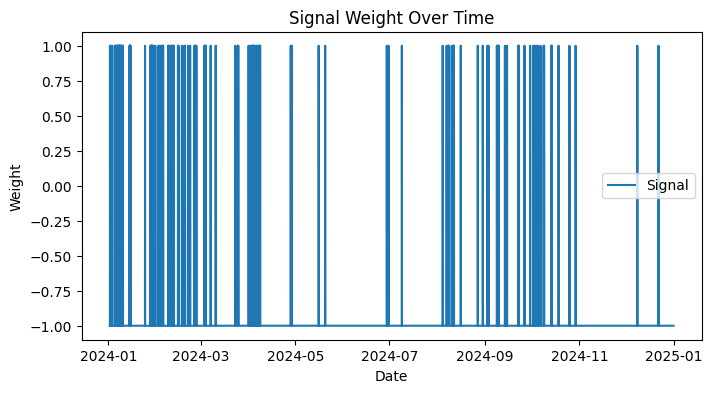

In [ ]:
run_backtest(stat_signal_result_df,name= "LSTM_CNN_Seq")

# Hybrid

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26284
Testing sequences: 8762


In [ ]:
# In the cell corresponding to id '90ec3b2b' (or similar model definition cell)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D

# ... existing imports ...
from tensorflow.keras.models import Sequential
# Add CNN layers to imports
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
import tensorflow as tf # Ensure tensorflow is imported
from tensorflow.keras.callbacks import LearningRateScheduler
# ... (Keep the sharpe_loss function definition if needed, or remove if using MSE) ...
# Assuming you want to keep the MSE loss as per the original cell:
# Remove or comment out the sharpe_loss definition and registration if not used.
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# --- Define CNN-LSTM Model Architecture ---
# Assuming X_train has shape (samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2]) 

model = Sequential() # Rename cnn_lstm_model to model to match existing code flow

# CNN Part
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same')) # Added padding
model.add(MaxPooling1D(pool_size=2))
# No Flatten needed if LSTM follows directly

# LSTM Part
model.add(LSTM(50, activation='relu', return_sequences=False)) # Changed units to 50, kept relu, return_sequences=False
model.add(Dropout(0.2)) # Kept dropout

# Dense Part (Simplified to match original LSTM output structure)
# model.add(Dense(25, activation='relu')) # Optional intermediate dense layer
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model (Matches the original cell's compilation)
model.compile(optimizer='adam', loss="mean_squared_error")

# Print model summary
model.summary()

# Add early stopping (Matches the original cell)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model (Matches the original cell)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model (Matches the original cell)
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions (Matches the original cell)
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (Matches the original cell)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
# The 'predictions' variable now holds the output, consistent with the rest of the notebook
# print(predictions) # Optional: print predictions if needed here

AttributeError: module 'matplotlib' has no attribute 'artist'

In [ ]:
model.save('hybrid_features_selection_lstm_cnn_M0.keras')  # HDF5 format


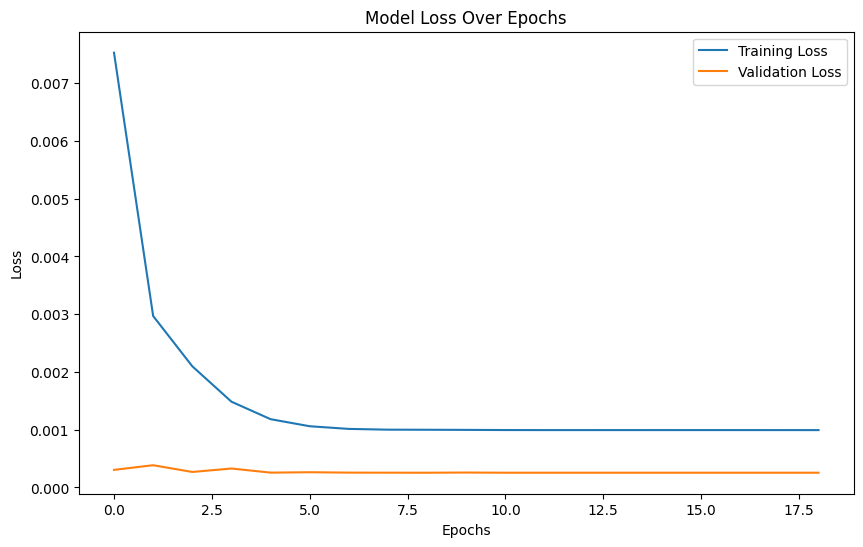

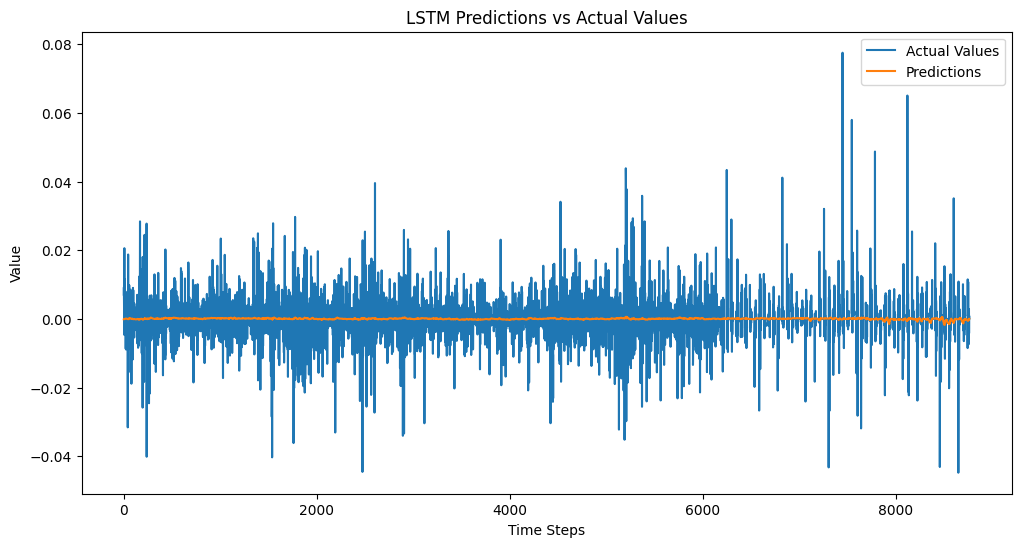

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('hybrid_features_selection_lstm_cnn_M0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

stat_signal_result_df

AttributeError: module 'matplotlib' has no attribute 'artist'

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.4166
Precision (Weighted): 0.3350
Recall (Weighted): 0.4166
F1 Score (Weighted): 0.3608
\nMetrics per class:
  Class -1:
    Precision: 0.3918
    Recall:    0.3147
    F1 Score:  0.3491
  Class 0:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
  Class 1:
    Precision: 0.4281
    Recall:    0.6955
    F1 Score:  0.5300


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 111.77%
Overall Annual Sharpe Ratio: 1.6849
Maximum Drawdown: -29.94 %
Alpha: 0.5484
Beta: 0.4877

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.117671    0.528101     0.487719      0.437211       1.684898


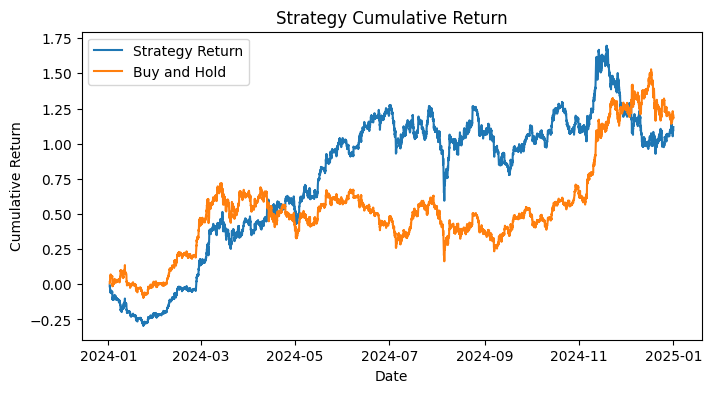

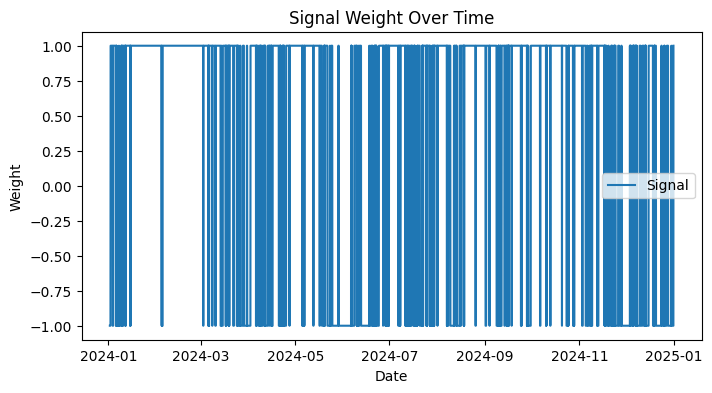

In [ ]:
run_backtest(stat_signal_result_df, name ="LSTM_CNN_Hybrid")